In [1]:
from tensorflow import keras
import shap
from lime import lime_tabular
import pandas as pd
import numpy as np
shap.initjs()
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import multiprocessing
import time
from tqdm import tqdm
from alibi.explainers import IntegratedGradients, ALE
import pickle as pk
import matplotlib.patches as mpatches

In [5]:
'''
FOLDER PATH TO ALL THE FILES
'''
FOLDERPATH = '../'

In [11]:
'''
OLD MODEL AND DATA
'''
model_path = FOLDERPATH+'tot_models/latest/model.h5'
test_data_path = FOLDERPATH+'old-data/test.csv'
train_data_path = FOLDERPATH+'old-data/v3.2.2_train.csv'

model = keras.models.load_model(model_path)
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

with open(FOLDERPATH+'old-data/old-data-randomIdx.pkl','rb') as f:
    randomIdx = pk.load(f)
f.close()

y_train,y_test = train_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']], test_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']]
X_train,X_test = train_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1),test_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1)

x_cols = list(X_train.columns)
y_cols = list(y_train.columns)

In [8]:
'''
# NEW MODEL AND DATA
'''
# dir_path = FOLDERPATH+'new-data/'
# modelName = 'best-FiveClass-RT-Oct-55-0.81.hdf5'
# dataName = ['X_train_enc.pkl','X_test_enc.pkl','y_train_enc.pkl','y_test_enc.pkl']

# model = keras.models.load_model(dir_path+modelName)

# data = []
# for name in dataName:
#     with open(dir_path+name,'rb') as f:
#         data.append(pk.load(f))
#     f.close()

# X_train, X_test, y_train, y_test = data

# with open(dir_path+'random_indexes.pkl','rb') as f:
#     randomIdx = pk.load(f)
# f.close()

# x_cols = ['FixationDuration', 'FixationSeq', 'FixationX', 'FixationY', 'GazeDirectionLeftZ', 'GazeDirectionRightZ', 'PupilLeft', 'PupilRight', 'InterpolatedGazeX', 'InterpolatedGazeY', 'AutoBrake', 'AutoThrottle', 'AutoWheel', 'CurrentThrottle', 'CurrentWheel', 'Distance3D', 'MPH', 'ManualBrake', 'ManualThrottle', 'ManualWheel', 'RightLaneDist', 'LeftLaneDist', 'LeftLaneType_0', 'LeftLaneType_1', 'RightLaneType_0', 'RightLaneType_1', 'NDTask_Cell', 'NDTask_Question', 'NDTask_Read', 'NDTask_Talk']
# y_cols = ['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']

# X_train = pd.DataFrame(X_train,columns=x_cols)
# X_test = pd.DataFrame(X_test,columns=x_cols)
# y_train = pd.DataFrame(y_train,columns=y_cols)
# y_test = pd.DataFrame(y_test,columns=y_cols)

In [10]:
'''
DROPPED DATA COLUMN
'''
# drop = ['FixationDuration','RangeW','AutoWheel']
# model_path = FOLDERPATH+'attribution-models/model-sans-{:}.h5'.format(''.join(drop))
# test_data_path = FOLDERPATH+'old-data/test.csv'
# train_data_path = FOLDERPATH+'old-data/v3.2.2_train.csv'

# model = keras.models.load_model(model_path)
# train_data = pd.read_csv(train_data_path)
# test_data = pd.read_csv(test_data_path)

# with open(FOLDERPATH+'old-data/old-data-randomIdx.pkl','rb') as f:
#     randomIdx = pk.load(f)
# f.close()

# y_train,y_test = train_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']], test_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']]
# X_train,X_test = train_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']+drop,axis=1),test_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']+drop,axis=1)

# x_cols = list(X_train.columns)
# y_cols = list(y_train.columns)

In [29]:
'''
Get labels and predictions
'''
test_labels = np.argmax(y_test.values,axis=1)
pred_vec = model.predict(X_test.values)
preds = np.argmax(pred_vec,axis=1)

n_classes = len(y_cols)
n_total_samples, n_features = X_train.shape
n_samples = len(randomIdx)

In [30]:
'''
FUNCTION DEFINITIONS
'''

def extract_imp_topK(values,k):
    n_classes = len(values)
    n_samples = values[0].shape[0]
    imp_feature,imp_score = np.zeros((n_samples,k,n_classes)),np.zeros((n_samples,n_classes))
    for i,val in enumerate(values):
        imp_score[:,i] = np.mean(np.sort(val,axis=-1)[:,-k:][:,::-1],axis=-1)
        imp_feature[:,:,i] = np.argsort(val,axis=-1)[:,-k:][:,::-1]
    
    return imp_feature, imp_score

def extract_imp_bottomK(values,k):
    n_classes = len(values)
    n_samples = values[0].shape[0]
    imp_feature,imp_score = np.zeros((n_samples,k,n_classes)),np.zeros((n_samples,n_classes))
    for i,val in enumerate(values):
        imp_score[:,i] = np.mean(np.sort(val,axis=-1)[:,:k],axis=-1)
        imp_feature[:,:,i] = np.argsort(val,axis=-1)[:,:k]
    
    return imp_feature, imp_score

def find_important_feature_K(values,preds,true_labels,k,which='top'):

    if which == 'top':
        imp_feature, imp_score = extract_imp_topK(values,k)
    else:
        imp_feature, imp_score = extract_imp_bottomK(values,k)

    n_samples,_,n_classes = imp_feature.shape
        
    imp_pred_class = np.zeros((n_samples,k))
    imp_pred_class_score = np.zeros(n_samples)
    for i in range(n_samples):
        imp_pred_class[i,:] = imp_feature[i,:,preds[i]]
        imp_pred_class_score[i] = imp_score[i,preds[i]]

    imp_corr_pred = imp_pred_class[np.where(preds==true_labels),:].squeeze()
    imp_incorr_pred = imp_pred_class[np.where(preds!=true_labels),:].squeeze()

    imp_corr_pred_score = imp_pred_class_score[np.where(preds==true_labels)]
    imp_incorr_pred_score = imp_pred_class_score[np.where(preds!=true_labels)]

    return imp_feature,imp_pred_class,imp_corr_pred,imp_incorr_pred,imp_score,imp_pred_class_score,imp_corr_pred_score,imp_incorr_pred_score

def plot_for_classes(imp_feature,x_cols,y_cols,n_features):

    plt.figure(1,figsize=(30,6))
    for i in range(imp_feature.shape[1]):
        plt.subplot(1,5,i+1)
        sns.barplot(x=list(Counter(imp_feature[:,i]).keys()),y=list(Counter(imp_feature[:,i]).values()))
        labs = [False]*n_features
        for j in sorted(list(Counter(imp_feature[:,i]).keys())): labs[int(j)] = True
        labs = np.array(x_cols)[labs]
        plt.xticks(ticks=range(len(labs)),labels=labs,rotation=90)
        plt.title(y_cols[i])


def plot_across_predictions(imp_pred_class,imp_corr_pred,imp_incorr_pred,x_cols,n_features):

    to_plot = [imp_pred_class,imp_corr_pred,imp_incorr_pred]
    plot_titles = ["Predicted class","Correctly predicted class","Incorrectly predicted class"]

    plt.figure(2,figsize=(22,6))
    for i in range(len(to_plot)):
        plt.subplot(1,3,i+1)
        sns.barplot(x=list(Counter(to_plot[i]).keys()),y=list(Counter(to_plot[i]).values()))
        labs = [False]*n_features
        for j in sorted(list(Counter(to_plot[i]).keys())): labs[int(j)] = True
        labs = np.array(x_cols)[labs]
        plt.xticks(ticks=range(len(labs)),labels=labs,rotation=90)
        plt.title(plot_titles[i])

def for_summary_plot(imp_pred_class,imp_corr_pred,imp_incorr_pred,values_pred,values_corr,values_incorr,i,k):

    for j in range(k):
        k1=np.array(list(Counter(imp_pred_class[:,j].flatten()).keys()),dtype=int)
        values_pred[k1,j,i]=np.array(list(Counter(imp_pred_class[:,j].flatten()).values()),dtype=int)
    for j in range(k):
        k2=np.array(list(Counter(imp_corr_pred[:,j].flatten()).keys()),dtype=int)
        values_corr[k2,j,i]=np.array(list(Counter(imp_corr_pred[:,j].flatten()).values()),dtype=int)
    for j in range(k):
        k3=np.array(list(Counter(imp_incorr_pred[:,j].flatten()).keys()),dtype=int)
        values_incorr[k3,j,i]=np.array(list(Counter(imp_incorr_pred[:,j].flatten()).values()),dtype=int)

    return values_pred,values_corr,values_incorr

def summary_plot(values,x_cols,k,fig,ax,title='Some class'):

    colors = ['#EA5739','#FEFFBE','#4BB05C','#4BE05C','#4EB05C']
    hatches = [None,'....','\\\\\\','****','/////']
    labels = ['First','Second','Third','Fourth','Fifth']

    x = np.arange(len(x_cols))  # the label locations
    width = 0.25  # the width of the bars

    # fig, ax = plt.subplots(figsize=(15,8))
    offset = np.zeros((values.shape[0],3))
    for i in range(k):
        rects1 = ax.bar(x - width, values[:,i,0], width, bottom=offset[:,0], \
                                                label='SHAP', color=colors[0], edgecolor="black", hatch=hatches[i])
        handleShap,labelShap = ax.get_legend_handles_labels()
        offset[:,0] += values[:,i,0]

        rects2 = ax.bar(x, values[:,i,1], width, bottom=offset[:,1], \
                                                label='LIME', color=colors[1], edgecolor="black", hatch=hatches[i])
        handleLime,labelLime = ax.get_legend_handles_labels()
        offset[:,1] += values[:,i,1]

        rects3 = ax.bar(x + width, values[:,i,2], width, bottom=offset[:,2], \
                                                label='IG', color=colors[2], edgecolor="black", hatch=hatches[i])
        handleIg,labelIg = ax.get_legend_handles_labels()
        offset[:,2] += values[:,i,2]

    ax.set_xlabel('Features')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(x_cols,rotation=90)
    legend1 = ax.legend([handleShap[0],handleLime[1],handleIg[2]],[labelShap[0],labelLime[1],labelIg[2]])

    patches = []
    for i in range(k):
        patches.append(mpatches.Patch(facecolor='white', hatch=hatches[i], edgecolor="black", label=labels[i]))

    legend2 = ax.legend(handles=patches,loc='center right',bbox_to_anchor=(1, 0.75))
    ax.add_artist(legend1)
    # fig.add_artist(legend2)
    # plt.legend()
    fig.tight_layout()

    # plt.show()
    plt.close()
    return fig,ax

In [5]:
'''
SHAP
'''
exp_shap = shap.DeepExplainer(model,X_train.values[randomIdx])
shap_values = exp_shap.shap_values(X_test.values[randomIdx])
# np.save('../importance/shap_values_old.npy',shap_values)

In [6]:
'''
Integrated Gradients
'''
ig  = IntegratedGradients(model,layer=None,method="gausslegendre",n_steps=50,internal_batch_size=100)
ig_values = [ig.explain(X_test.values[randomIdx],baselines=None,target=t).attributions for t in [0,1,2,3,4]]
# np.save('../importance/ig_values_old.npy',ig_values)

In [8]:
'''
LIME
Note: Takes times
'''

explainer = lime_tabular.LimeTabularExplainer(X_train.values[randomIdx], feature_names=X_train.columns, class_names=y_train.columns,discretize_continuous=True)
lime_values = np.zeros((5,len(randomIdx),X_train.shape[1]))
start = time.time()
for i,sample in tqdm(enumerate(X_test.values[randomIdx])):
    exp_lime = explainer.explain_instance(sample, model.predict, labels=[0,1,2,3,4])
    content = exp_lime.as_map()
    
    for c in list(content.keys()):
        samp_value = np.zeros(X_train.shape[1])
        for j,k in np.array(content[c]):
            samp_value[int(j)] = k
        lime_values[c,i,:] = samp_value

# np.save('lime_values_new.npy',lime_values)

'\nLIME\n'

In [12]:
'''
Load importance values
'''
t = 'old'
lime_values = np.load(FOLDERPATH+'importance-data/lime_values_{d}.npy'.format(d=t))
shap_values = np.load(FOLDERPATH+'importance-data/shap_values_{d}.npy'.format(d=t))
ig_values = np.load(FOLDERPATH+'importance-data/ig_values_{d}.npy'.format(d=t))

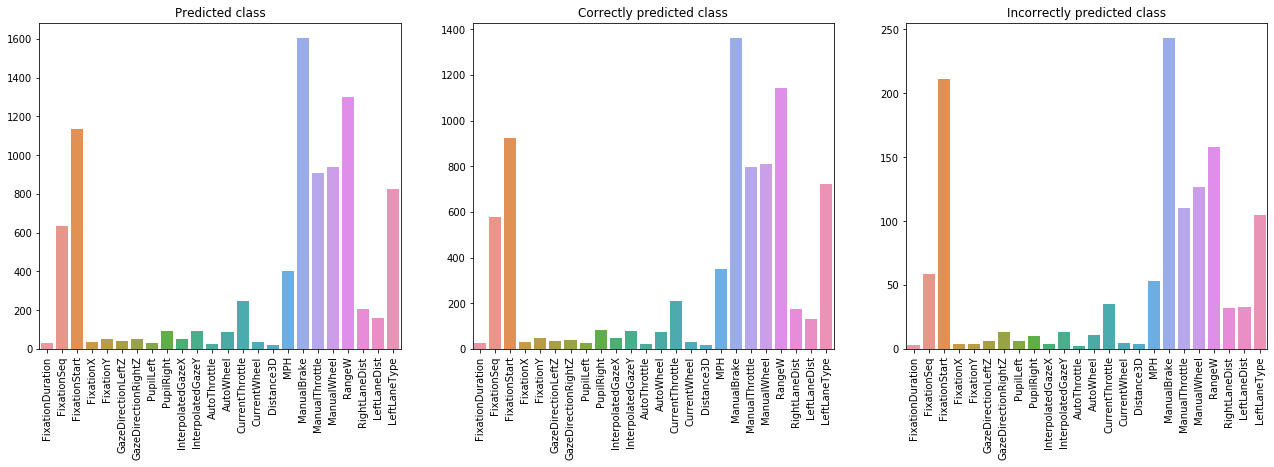

In [32]:
'''
Plots for LIME
'''
imp_feature,imp_pred_class,imp_corr_pred,imp_incorr_pred,imp_score,imp_pred_class_score,imp_corr_pred_score,imp_incorr_pred_score = find_important_feature_K(lime_values,preds[randomIdx],test_labels[randomIdx],3,'top')

# plot_for_classes(imp_feature.reshape(n_samples*k,-1),x_cols,y_cols,n_features)
plot_across_predictions(imp_pred_class.flatten(),imp_corr_pred.flatten(),imp_incorr_pred.flatten(),x_cols,n_features)

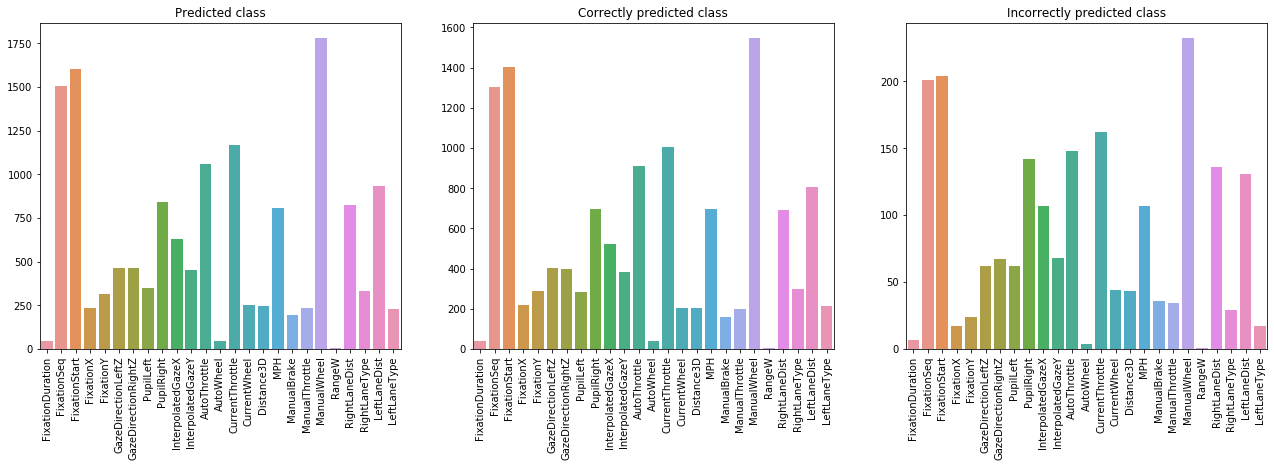

In [33]:
'''
Plots for SHAP
'''
imp_feature,imp_pred_class,imp_corr_pred,imp_incorr_pred,imp_score,imp_pred_class_score,imp_corr_pred_score,imp_incorr_pred_score = find_important_feature_K(shap_values,preds[randomIdx],test_labels[randomIdx],5,'top')

# plot_for_classes(imp_feature.reshape(n_samples*k,-1),x_cols,y_cols,n_features)
plot_across_predictions(imp_pred_class.flatten(),imp_corr_pred.flatten(),imp_incorr_pred.flatten(),x_cols,n_features)

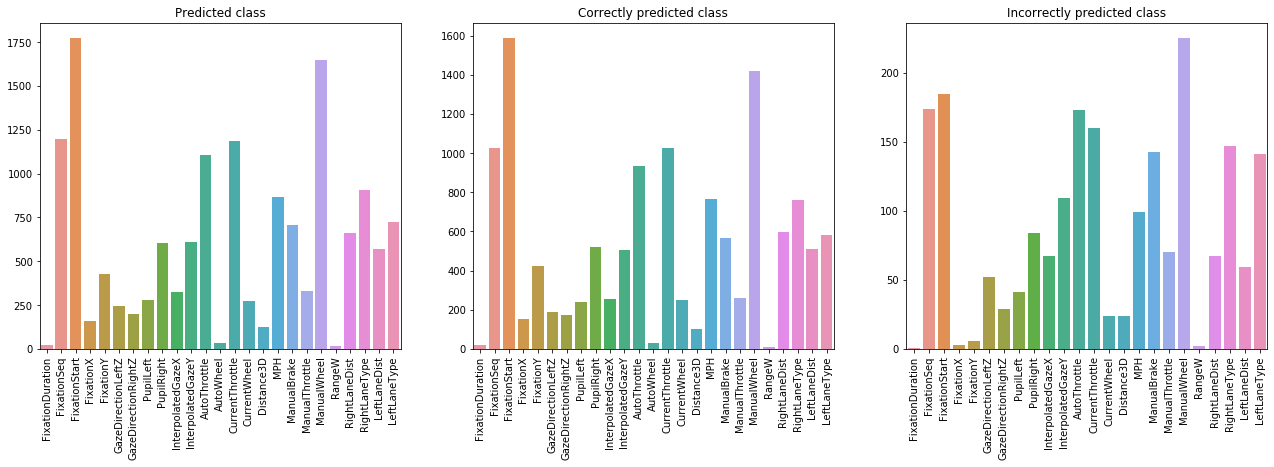

In [34]:
'''
Plots for IG
'''
imp_feature,imp_pred_class,imp_corr_pred,imp_incorr_pred,imp_score,imp_pred_class_score,imp_corr_pred_score,imp_incorr_pred_score = find_important_feature_K(ig_values,preds[randomIdx],test_labels[randomIdx],5,'top')

# plot_for_classes(imp_feature.reshape(n_samples*k,-1),x_cols,y_cols,n_features)
plot_across_predictions(imp_pred_class.flatten(),imp_corr_pred.flatten(),imp_incorr_pred.flatten(),x_cols,n_features)

In [35]:
'''
Summarizing importance charts for three algorithms
'''
k = 5
which= 'top'
types = 3
values_pred = np.zeros((n_features,k,types),dtype=int)
values_corr = np.zeros((n_features,k,types),dtype=int)
values_incorr = np.zeros((n_features,k,types),dtype=int)

imp_values = [shap_values,lime_values,ig_values]
# imp_values = [shap_values,ig_values]

for i in range(types):
    _,imp_pred_class,imp_corr_pred,imp_incorr_pred,_,_,_,_ = find_important_feature_K(imp_values[i],preds[randomIdx],test_labels[randomIdx],k,which)
    values_pred,values_corr,values_incorr = for_summary_plot(imp_pred_class,imp_corr_pred,imp_incorr_pred,values_pred,values_corr,values_incorr,i,k)

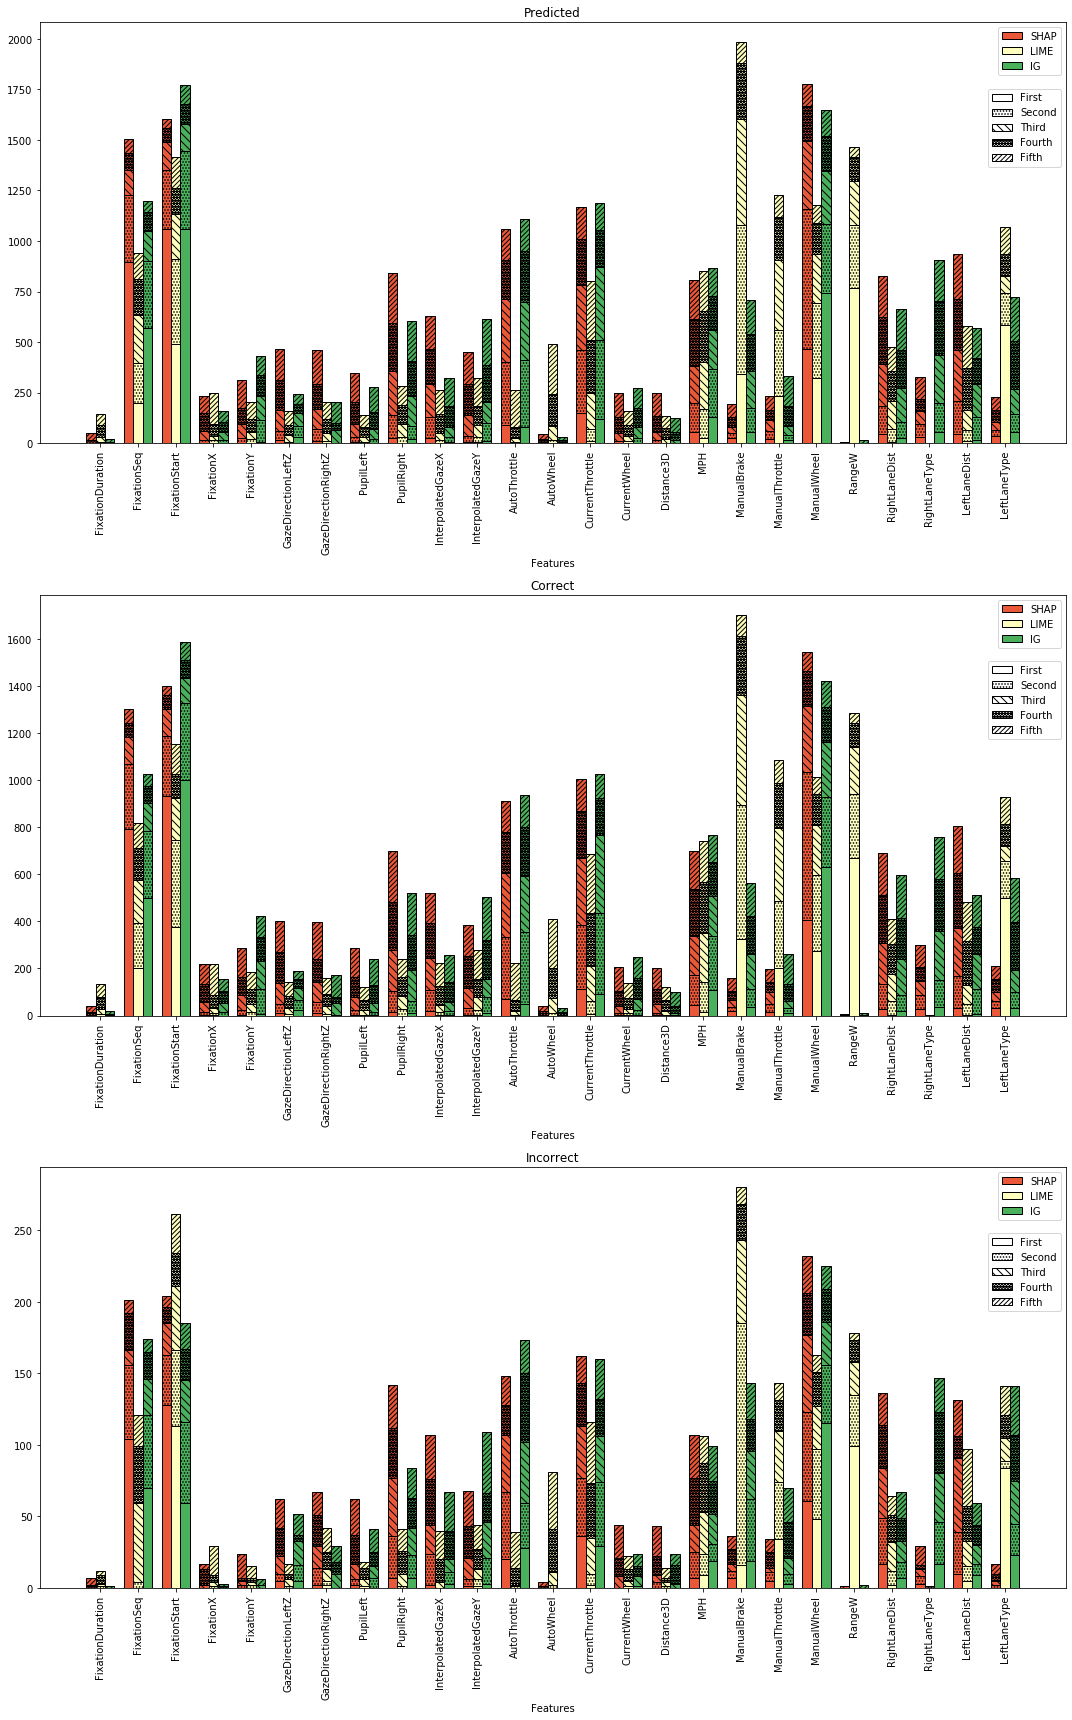

In [36]:
fig, axes = plt.subplots(3,1,figsize=(15,24))

labels = ['Predicted','Correct','Incorrect']
values = [values_pred,values_corr,values_incorr]
for i,ax in enumerate(axes):
    fig,ax = summary_plot(values[i],x_cols,k,fig,ax,labels[i])
# plt.show()

In [13]:
fig.savefig(FOLDERPATH+'results/top-{d}-imp-chart-new.pdf'.format(d=k),format='pdf')

NameError: name 'fig' is not defined